#Volatility modelling beyond BSM
##Local volatility
There are different models that go beyond the Black-Scholes model.
One of them is the local volatility.

We are not going to take a volatility that is constant, but now the volatility is a deterministic function that depends on the stock price and the time i.e., $\sigma = \sigma(S_t, t)$.  

### Implications:
- **Non-normal distribution of log-returns:** In the BSM model, log-returns are normally distributed, but in the local volatility model, this assumption no longer holds. The price distribution incorporates volatility skew and smile effects observed in real markets.
- **Single source of randomness:** There is still only one stochastic factor, the Brownian motion $W_t$, meaning the model remains one-dimensional in terms of risk.
- **Connection to implied volatility:** The function $\sigma(S_t, t)$ can be calibrated using the implied volatility surface derived from option prices. A well-known approach that leverages this idea is Dupire's model, which provides an equation to determine $\sigma(S_t, t)$ from European option prices.



We could calibrate the local volatility model in two ways:
1. parametric way, that assumes the local volatility depends on several parameters calibrated looking at the market;
2. solving Dupire's formula.

##Dupire's formula
Dupire’s formula provides a way to extract the instantaneous (local) volatility from the prices of European options across strikes and maturities. In its most common form—assuming a non‐dividend–paying asset—the formula is written as

$
\sigma_{\text{loc}}^2(K,T) = \frac{\partial_T C(K,T) + r\,K\,\partial_K C(K,T)}{\tfrac{1}{2}K^2\,\partial_{KK} C(K,T)},
$

where

- $C(K,T)$ is the price of a European call option with strike $K$ and maturity $T$,
- $\partial_T C(K,T)$ denotes the partial derivative of $C$ with respect to time (maturity),
- $\partial_K C(K,T)$ and $\partial_{KK} C(K,T)$ are the first and second partial derivatives with respect to the strike,
- $r$ is the risk–free interest rate.

If the underlying asset pays a continuous dividend yield $q$, the formula is adjusted to

$
\sigma_{\text{loc}}^2(K,T) = \frac{\partial_T C(K,T) + q\,C(K,T) + (r-q)\,K\,\partial_K C(K,T)}{\tfrac{1}{2}K^2\,\partial_{KK} C(K,T)}.
$

In these expressions, the numerator captures the dynamics of the option’s time decay (and drift effects when $r$ or $q$ are nonzero), while the denominator involves the curvature (or convexity) of the option price with respect to the strike, which is directly related to the risk-neutral density, through the Breeden-Litzenberger model.
### **Key Insights:**
1. **Extracting Local Volatility from Market Data:**  
   - We use observed option prices across different strikes $K $ and maturities $T$.
   - By computing derivatives numerically, we estimate the local volatility function.
   - We need an interpolation technique to get all the prices.

2. **Link to the Implied Volatility Surface:**  
   - The local volatility model is consistent with all observed European option prices, meaning it fully describes the implied volatility surface, despite its limitations.
   - Unlike the Black-Scholes model, which assumes constant volatility, the local volatility model captures **volatility smiles and skews**.

In [224]:
import seaborn as sns
!pip install --upgrade yfinance
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize_scalar
from scipy.stats import norm
from scipy.ndimage import gaussian_filter



In [225]:
N_1=norm.cdf

In [226]:
sp500= yf.Ticker("SPY")
hist=sp500.history(period="1y")
last_stock_price=hist["Close"].iloc[-1]
last_stock_price

594.5399780273438

In [227]:
expiration=sp500.options
chosen_expiration= expiration[15]
options_g=sp500.option_chain(expiration[15])
call_op= options_g.calls.dropna()
call_op

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY250530C00385000,2025-02-13 20:51:40+00:00,385.0,228.82,0.0,0.0,0.0,0.0,2,0,0.000010,True,REGULAR,USD
1,SPY250530C00390000,2025-02-12 19:59:18+00:00,390.0,218.82,0.0,0.0,0.0,0.0,2,0,0.000010,True,REGULAR,USD
2,SPY250530C00395000,2025-02-13 20:13:05+00:00,395.0,219.15,0.0,0.0,0.0,0.0,2,0,0.000010,True,REGULAR,USD
3,SPY250530C00400000,2025-02-18 19:47:53+00:00,400.0,214.07,0.0,0.0,0.0,0.0,2,0,0.000010,True,REGULAR,USD
4,SPY250530C00405000,2025-02-13 16:42:56+00:00,405.0,206.82,0.0,0.0,0.0,0.0,2,0,0.000010,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,SPY250530C00700000,2025-02-26 20:44:00+00:00,700.0,0.06,0.0,0.0,0.0,0.0,73,0,0.062509,False,REGULAR,USD
135,SPY250530C00705000,2025-02-26 16:28:59+00:00,705.0,0.05,0.0,0.0,0.0,0.0,3,0,0.062509,False,REGULAR,USD
136,SPY250530C00710000,2025-02-25 15:19:27+00:00,710.0,0.05,0.0,0.0,0.0,0.0,1,0,0.062509,False,REGULAR,USD
137,SPY250530C00715000,2025-02-18 19:44:39+00:00,715.0,0.10,0.0,0.0,0.0,0.0,1,0,0.062509,False,REGULAR,USD


In [228]:
chosen_expiration

'2025-05-30'

First of all, I will find the implied volatilities from BSM.

In [229]:
def time_to_maturity(expiration,trade):
  exp = pd.to_datetime(expiration).tz_localize(None) # Make exp timezone-naive
  trade = pd.to_datetime(trade).tz_localize(None) # Make trade timezone-naive
  time_diff = (exp - trade).days
  time_diff = time_diff / 365
  return time_diff
time_to_maturities= call_op.apply(lambda row:time_to_maturity(chosen_expiration,row["lastTradeDate"]), axis=1)
time_to_maturities

,0
0,0.287671
1,0.290411
2,0.287671
3,0.273973
4,0.287671
...,...
134,0.252055
135,0.252055
136,0.254795
137,0.273973


In [230]:
def bsm_model(S,K,T,r,sigma,option_type="call"):
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)

  if option_type == 'call':
      pay_off_call= S * N_1(d1) - K * np.exp(-r * T) * N_1(d2)
  else:
      pay_off_put= K * np.exp(-r * T) * N_1(-d2) - S * N_1(-d1)

  return pay_off_call


In [231]:
call_op['mid_price'] = (call_op['bid'] + call_op['ask']) / 2

In [232]:
def impl_vol(S,K,T,r,model_price,option_type="call"):
  payoff= lambda sigma:(bsm_model(S,K,T,r,sigma,option_type="call")-model_price)**2
  result= minimize_scalar(payoff,method="bounded", bounds=(0.01,3))
  return result.x if result.success else np.nan

implied_volatility= call_op.apply(lambda row: impl_vol(last_stock_price,row["strike"], time_to_maturity(chosen_expiration, row["lastTradeDate"]), 0.485, row["mid_price"]),axis=1)
implied_volatility

,0
0,0.093996
1,0.134356
2,0.131159
3,0.123186
4,0.124972
...,...
134,0.010004
135,0.010005
136,0.010004
137,0.010007


Then, I need to use the interpolation technique.

In [233]:
from scipy.interpolate import SmoothBivariateSpline
from mpl_toolkits.mplot3d import Axes3D
x = np.array(call_op["strike"])
y = np.array(time_to_maturities)
z = np.array(implied_volatility)
strike_range = np.linspace(min(call_op["strike"]), max(call_op["strike"]), num=100)
maturity_range = np.linspace(min(time_to_maturities), max(time_to_maturities), num=100)
K_mesh, T_mesh = np.meshgrid(strike_range, maturity_range)

spline = SmoothBivariateSpline(x, y, z, kx=3, ky=3, s=0.1)
IV = spline.ev(K_mesh.ravel(), T_mesh.ravel()).reshape(K_mesh.shape)
IV = np.maximum(IV, 1e-6)
IV

array([[0.11881017, 0.11807421, 0.11728373, ..., 0.0143909 , 0.01533958,
        0.01637901],
       [0.12181751, 0.12076826, 0.11967869, ..., 0.01661643, 0.01747563,
        0.01841573],
       [0.12467958, 0.12332781, 0.12194975, ..., 0.01772866, 0.01845548,
        0.01925245],
       ...,
       [0.11301859, 0.11777282, 0.12148566, ..., 3.40675531, 3.55306164,
        3.70338006],
       [0.11389979, 0.118934  , 0.12287626, ..., 3.56499164, 3.71821872,
        3.87564784],
       [0.114885  , 0.12020053, 0.12437242, ..., 3.72761469, 3.88795235,
        4.05268711]])

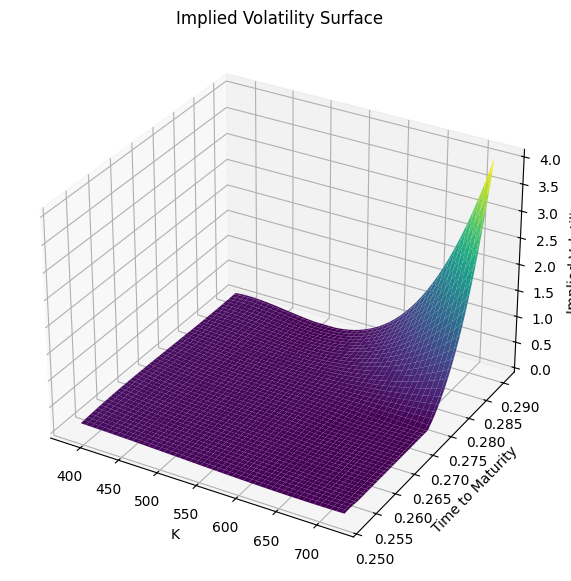

In [234]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_mesh, T_mesh, IV, cmap='viridis', edgecolor='none')

# Labels
ax.set_xlabel("K")
ax.set_ylabel("Time to Maturity")
ax.set_zlabel("Implied Volatility")
ax.set_title("Implied Volatility Surface")

plt.show()


In [235]:
bsm_prices=bsm_model(last_stock_price,K_mesh,T_mesh,0.485,IV)
bsm_prices

array([[2.53841874e+02, 2.50847414e+02, 2.47852953e+02, ...,
        3.39651177e-17, 1.50412161e-17, 1.12708142e-17],
       [2.53905888e+02, 2.50911990e+02, 2.47918092e+02, ...,
        3.29446099e-13, 8.47883264e-14, 3.18392961e-14],
       [2.53969889e+02, 2.50976554e+02, 2.47983218e+02, ...,
        1.05405896e-11, 1.91220847e-12, 4.64239303e-13],
       ...,
       [2.59995502e+02, 2.57055127e+02, 2.54114752e+02, ...,
        3.76472546e+02, 3.88287577e+02, 4.00024944e+02],
       [2.60058360e+02, 2.57118537e+02, 2.54178714e+02, ...,
        3.89966800e+02, 4.01868501e+02, 4.13646600e+02],
       [2.60121205e+02, 2.57181935e+02, 2.54242664e+02, ...,
        4.03273689e+02, 4.15210969e+02, 4.26975672e+02]])

The next step is to calculate the **Dupire's formula** by using the ```
np.gradient()```

As we have seen above we need to calculate the derivative wrt T and K.
For istance, when we calculate the second derivative of the call prices wrt K, we are basically extracting the risk neutral densities as the **Breeden Litzenberger** model explained.

For that reason, we need to ensure the validity and the consistency of this model by taking positive values, since the densities are positive.

In addition, in order to filter our volatility surface, it is very useful using the **gaussian filter** that is a way to remove noise keeping the important information structure. It basically gives weights to the nearby points according the normal distribution function.


In [240]:
def calculate_local_volatility(bsm_model, S, K_mesh, T_mesh, IV, maturity_range, strike_range):
    delta_T = np.gradient(maturity_range)
    delta_K = np.gradient(strike_range)
    call_prices=bsm_model(last_stock_price, K_mesh, T_mesh, 0.0485, IV)
    dC_dT = np.gradient(call_prices, maturity_range, axis=0, edge_order=2)
    dC_dK= np.gradient(call_prices, strike_range, axis=1 , edge_order=2)
    d2C_dK2 = np.gradient(dC_dK, strike_range, axis=1, edge_order=1)
    d2C_dK2=np.maximum(d2C_dK2,1e-6)  #it is useful for avoiding negative values, since from the Breeden Litzenberger model we are extracting the densities that are positive.
    sigma_local = np.sqrt(np.maximum((dC_dT + 0.0485 * K_mesh * dC_dK) / (0.5 * K_mesh**2 * d2C_dK2),1e-6))

    return sigma_local, d2C_dK2

sigma_local, d2C_dK2 = calculate_local_volatility(bsm_model, last_stock_price, K_mesh, T_mesh, IV, maturity_range, strike_range)
sigma_local= gaussian_filter(sigma_local,sigma=1)


Text(0.5, 0.92, "Local Volatility Surface using Dupire's Formula")

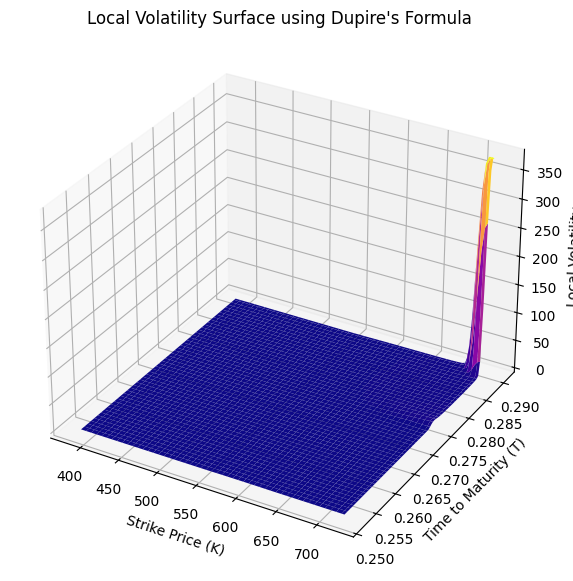

In [241]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_mesh, T_mesh, sigma_local, cmap='plasma', edgecolor='none')

ax.set_xlabel("Strike Price (K)")
ax.set_ylabel("Time to Maturity (T)")
ax.set_zlabel("Local Volatility")
ax.set_title("Local Volatility Surface using Dupire's Formula")

## Conclusion
The local volatility gives important results in terms of estimation of the volatility that goes beyond the BSM.

But unfortunately, the market behaviour of the volatility is purely stochastic and due by randomness and the local volatility itself is not able to capture these patterns.

In addition, it could have issues capturing the **leverage effect**. In the specific, the volatility could be low for low spot prices, being a function of spot prices and maturities.

That's why it was introduce a variation: the stochastic local volatility.